## Import Libraries

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
import pandas as pd
import requests
import glob

## Basic Information about the dataset

Upload the dataset, then use .head() and .info() to gain a general understanding of what's included. 

In [2]:
## upload the dataset
county_data = pd.read_excel("../data/indicators.xlsx")

In [3]:
## take a look at the first 10 rows, including the header
county_data.head(10)

,county,party_dem_2008,party_dem_2012,party_dem_2016,party_dem_2020,party_dem_2024,party_rep_2008,party_rep_2012,party_rep_2016,party_rep_2020,...,mixed_race_2020,population_2024,male_2024,female_2024,older_adults_2024,hispanic_2024,white_2024,black_2024,asian_2024,mixed_race_2024
0,atlantic,52126,50591,56878,72772,69648,42076,41745,44357,54398,...,8234,274339,133897,140442,51456,54178,150753,35485,21120,11210
1,bergen,171379,170109,201413,258794,256911,111872,111696,123563,145805,...,18237,953243,467592,485651,167276,205545,509075,50172,157669,23583
2,burlington,91746,94214,110786,136381,143277,65518,67668,75120,87934,...,15514,461853,228468,233385,81197,41114,299166,73251,24967,20108
3,camden,139147,141099,154353,185839,182680,43669,44438,49000,61164,...,11346,522581,253604,268977,83495,94913,284011,94675,30724,14701
4,cape_may,14405,13798,15661,18930,18501,27638,27402,28107,31740,...,2182,95456,46347,49109,26529,7960,80479,3376,764,2606
5,cumberland,25684,15427,28023,33770,31910,15472,25500,16689,21424,...,3751,153588,78755,74833,23937,49802,67762,27133,2194,4582
6,essex,209583,219383,259419,294191,302750,45790,45453,49843,56504,...,17070,853374,414982,438392,117405,204966,242992,312788,48235,30510
7,gloucester,71782,69900,77790,89628,83702,35397,37239,42898,55460,...,6769,302621,148499,154122,48955,21577,230995,30333,9724,8543
8,hudson,173890,169160,185409,227028,222270,27230,26972,30471,41780,...,14402,712029,356520,355509,86664,302289,197105,74216,112065,19885
9,hunterdon,17712,17678,21530,28485,31204,32935,34810,37562,41056,...,1830,129099,63792,65307,25330,9396,107167,3067,5716,3093


In [4]:
## look at other information related to the dataset
county_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Columns: 106 entries, county to mixed_race_2024
dtypes: float64(5), int64(100), object(1)
memory usage: 17.5+ KB


## Clustering preparation

Before clustering the data, some of the indicators need to be transformed into rates. Those include:
- political-party affiliation
- foreign-born population
- black, asian and hispanic populations
- college-educated population

We also need to normalize some columns so that they're also read as rates. Otherwise, the K-means analysis won't work (data needs to be read on a scale of 0-1). Those include:
- unemployment rate
- median income

In [5]:
## republican percentages
county_data["pct_rep_08"] = county_data["party_rep_2008"]/(county_data["party_rep_2008"] + county_data["party_dem_2008"] + county_data["party_none_2008"])
county_data["pct_rep_12"] = county_data["party_rep_2012"]/(county_data["party_rep_2012"] + county_data["party_dem_2012"] + county_data["party_none_2012"])
county_data["pct_rep_16"] = county_data["party_rep_2016"]/(county_data["party_rep_2016"] + county_data["party_dem_2016"] + county_data["party_none_2016"])
county_data["pct_rep_20"] = county_data["party_rep_2020"]/(county_data["party_rep_2020"] + county_data["party_dem_2020"] + county_data["party_none_2020"])
county_data["pct_rep_24"] = county_data["party_rep_2024"]/(county_data["party_rep_2024"] + county_data["party_dem_2024"] + county_data["party_none_2024"])

In [6]:
## democrat percentages
county_data["pct_dem_08"] = county_data["party_dem_2008"]/(county_data["party_rep_2008"] + county_data["party_dem_2008"] + county_data["party_none_2008"])
county_data["pct_dem_12"] = county_data["party_dem_2012"]/(county_data["party_rep_2012"] + county_data["party_dem_2012"] + county_data["party_none_2012"])
county_data["pct_dem_16"] = county_data["party_dem_2016"]/(county_data["party_rep_2016"] + county_data["party_dem_2016"] + county_data["party_none_2016"])
county_data["pct_dem_20"] = county_data["party_dem_2020"]/(county_data["party_rep_2020"] + county_data["party_dem_2020"] + county_data["party_none_2020"])
county_data["pct_dem_24"] = county_data["party_dem_2024"]/(county_data["party_rep_2024"] + county_data["party_dem_2024"] + county_data["party_none_2024"])

In [7]:
## unaffiliated percentages
county_data["pct_none_08"] = county_data["party_none_2008"]/(county_data["party_rep_2008"] + county_data["party_dem_2008"] + county_data["party_none_2008"])
county_data["pct_none_12"] = county_data["party_none_2012"]/(county_data["party_rep_2012"] + county_data["party_dem_2012"] + county_data["party_none_2012"])
county_data["pct_none_16"] = county_data["party_none_2016"]/(county_data["party_rep_2016"] + county_data["party_dem_2016"] + county_data["party_none_2016"])
county_data["pct_none_20"] = county_data["party_none_2020"]/(county_data["party_rep_2020"] + county_data["party_dem_2020"] + county_data["party_none_2020"])
county_data["pct_none_24"] = county_data["party_none_2024"]/(county_data["party_rep_2024"] + county_data["party_dem_2024"] + county_data["party_none_2024"])

In [8]:
## foreign-born population percentages
county_data["pct_foreign_born_08"] = county_data["foreign_born_2008"]/county_data["population_2008"]
county_data["pct_foreign_born_12"] = county_data["foreign_born_2012"]/county_data["population_2012"]
county_data["pct_foreign_born_16"] = county_data["foreign_born_2016"]/county_data["population_2016"]
county_data["pct_foreign_born_20"] = county_data["foreign_born_2020"]/county_data["population_2020"]
county_data["pct_foreign_born_24"] = county_data["foreign_born_2024"]/county_data["population_2024"]

In [9]:
## black population percentages
county_data["pct_black_08"] = county_data["black_2008"]/(county_data["population_2008"])
county_data["pct_black_12"] = county_data["black_2012"]/(county_data["population_2012"])
county_data["pct_black_16"] = county_data["black_2016"]/(county_data["population_2016"])
county_data["pct_black_20"] = county_data["black_2020"]/(county_data["population_2020"])
county_data["pct_black_24"] = county_data["black_2024"]/(county_data["population_2024"])

In [10]:
## asian population
county_data["pct_asian_08"] = county_data["asian_2008"]/(county_data["population_2008"])
county_data["pct_asian_12"] = county_data["asian_2012"]/(county_data["population_2012"])
county_data["pct_asian_16"] = county_data["asian_2016"]/(county_data["population_2016"])
county_data["pct_asian_20"] = county_data["asian_2020"]/(county_data["population_2020"])
county_data["pct_asian_24"] = county_data["asian_2024"]/(county_data["population_2024"])

In [11]:
## hispanic population
county_data["pct_hispanic_08"] = county_data["hispanic_2008"]/(county_data["population_2008"])
county_data["pct_hispanic_12"] = county_data["hispanic_2012"]/(county_data["population_2012"])
county_data["pct_hispanic_16"] = county_data["hispanic_2016"]/(county_data["population_2016"])
county_data["pct_hispanic_20"] = county_data["hispanic_2020"]/(county_data["population_2020"])
county_data["pct_hispanic_24"] = county_data["hispanic_2024"]/(county_data["population_2024"])

In [12]:
## college-educated population
county_data["pct_college_08"] = county_data["college_degree_2008"]/(county_data["population_2008"])
county_data["pct_college_12"] = county_data["college_degree_2012"]/(county_data["population_2012"])
county_data["pct_college_16"] = county_data["college_degree_2016"]/(county_data["population_2016"])
county_data["pct_college_20"] = county_data["college_degree_2020"]/(county_data["population_2020"])
county_data["pct_college_24"] = county_data["college_degree_2024"]/(county_data["population_2024"])

In [13]:
## normalizing unemployment rates
county_data["unemployed_08"] = county_data["unemployed_rate_2008"]/100
county_data["unemployed_12"] = county_data["unemployed_rate_2012"]/100
county_data["unemployed_16"] = county_data["unemployed_rate_2016"]/100
county_data["unemployed_20"] = county_data["unemployed_rate_2020"]/100
county_data["unemployed_24"] = county_data["unemployed_rate_2024"]/100

In [14]:
## normalizing median income
county_data["income_08"] = county_data["median_income_2008"]/county_data["median_income_2008"].max()
county_data["income_12"] = county_data["median_income_2012"]/county_data["median_income_2012"].max()
county_data["income_16"] = county_data["median_income_2016"]/county_data["median_income_2016"].max()
county_data["income_20"] = county_data["median_income_2020"]/county_data["median_income_2020"].max()
county_data["income_24"] = county_data["median_income_2024"]/county_data["median_income_2024"].max()

## Mapping

Merge the above dataset with a geojson file of new jersey counties.

In [15]:
## read in county shapefiles
counties = gpd.read_file("../data/counties")

/Users/miahollie/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: ../data/counties/NJ_Counties_3424.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


In [16]:
## just checking to make sure it's a geodataframe
print(type(counties))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [17]:
## changing county names to lower case so that we can join this file with the original dataset
counties["COUNTY"] = counties["COUNTY"].str.lower()

In [18]:
## join both datasets
combined = pd.merge(
    county_data,
    counties,
    left_on = "county",
    right_on = "COUNTY"
)

In [19]:
## check the dataframe type again
## we'll need to change it into a geodataframe
print(type(combined))

<class 'pandas.core.frame.DataFrame'>


In [20]:
## turn into GeoDataFrame
combined_geo = gpd.GeoDataFrame(
    combined,
    geometry= combined.geometry,
    crs="EPSG:4326")

In [21]:
## checking the dataframe type again
print(type(combined_geo))

<class 'geopandas.geodataframe.GeoDataFrame'>


## Kmeans analysis

The following analysis seeks to answer the following questions: how do NJ counties relate to each other? How have those relations changed over time? 

We can do a K-means analysis to group the state's 23 counties according to the various indicators we've collected. We can do this by performing a K-means analysis for each election year. 

By the end of the analysis, we'll have grouping that can be compared to elections results data. 

### 2008

In [22]:
## identify the indicators we want to analyze
features_2008 = [
    'pct_college_08',
    'pct_hispanic_08',
    'pct_black_08',
    'pct_asian_08',
    'pct_rep_08',
    'pct_dem_08',
    'pct_none_08',
    'pct_foreign_born_08',
    'unemployed_08',
    'income_08'
]

In [23]:
## create an empty array to write the kmeans to
inertias = []

In [24]:
for i in range(1,10): # <-- loop through...
    kmeans = KMeans(n_clusters=i) # <-- assign every "i" in the loop to n_clusters, perform kmeans on each
    kmeans.fit(combined_geo[features_2008]) # <-- fit the model to each feature
    inertias.append(kmeans.inertia_) # <-- measure how well the dataset was clustered by kmeans

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

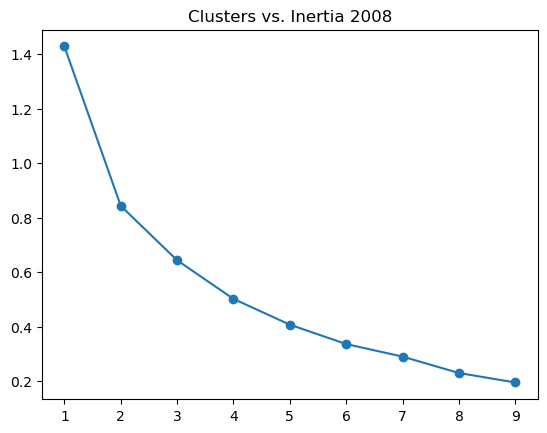

In [25]:
## plot the clusters and their inertia
## use the 'elbow' method to find where the line starts to even out
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia 2008')
plt.show()

In [26]:
## the line started to even out around 6
kmeans = KMeans(n_clusters=6, random_state=42) # <-- create 6 clusters, use a random state
kmeans.fit(combined_geo[features_2008]) # <-- fit the model to the '08 features

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [27]:
## create a new column to store the kmeans labels
combined_geo['kmeans_label_08'] = kmeans.labels_

In [28]:
## count the number of counties in each kmeans category
combined_geo['kmeans_label_08'].value_counts()

kmeans_label_08
5    4
0    4
4    4
2    4
1    2
3    2
Name: count, dtype: int64

<Axes: >

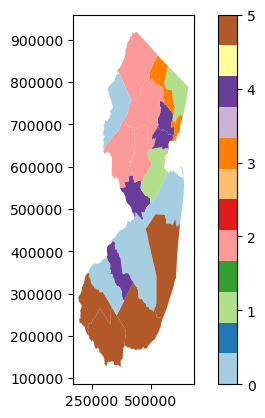

In [29]:
## plot the kmeans labels on the counties map we created earlier
combined_geo.plot(
    column = "kmeans_label_08",
    cmap = "Paired",
    legend = True)

In [30]:
## find the average kmeans of all counties in each category
cluster_feature_averages_08 = combined_geo.groupby('kmeans_label_08')[features_2008].mean().T
cluster_feature_averages_08

kmeans_label_08,0,1,2,3,4,5
pct_college_08,0.142383,0.174453,0.181116,0.133423,0.127344,0.093259
pct_hispanic_08,0.064774,0.162871,0.085086,0.387904,0.182036,0.138025
pct_black_08,0.089351,0.069241,0.038448,0.115995,0.245681,0.126515
pct_asian_08,0.035021,0.172711,0.067219,0.089060,0.055971,0.027412
pct_rep_08,0.246151,0.164496,0.340250,0.129300,0.131612,0.220103
pct_dem_08,0.293605,0.343762,0.213998,0.405289,0.417077,0.274516
pct_none_08,0.460244,0.491742,0.445752,0.465410,0.451311,0.505381
pct_foreign_born_08,0.089016,0.288708,0.138075,0.338669,0.205541,0.093263
unemployed_08,0.049750,0.046500,0.041250,0.064000,0.056500,0.066500
income_08,0.749037,0.788884,0.936463,0.545747,0.629107,0.555749


In [31]:
## find how much each of the groupings averages vary according to individual kmeans averages
cluster_feature_averages_08['variance'] = cluster_feature_averages_08.apply(lambda x: x.var(), axis=1)
cluster_feature_averages_08.sort_values('variance', ascending = False)

kmeans_label_08,0,1,2,3,4,5,variance
income_08,0.749037,0.788884,0.936463,0.545747,0.629107,0.555749,0.023169
pct_hispanic_08,0.064774,0.162871,0.085086,0.387904,0.182036,0.138025,0.013397
pct_foreign_born_08,0.089016,0.288708,0.138075,0.338669,0.205541,0.093263,0.010862
pct_rep_08,0.246151,0.164496,0.340250,0.129300,0.131612,0.220103,0.006594
pct_dem_08,0.293605,0.343762,0.213998,0.405289,0.417077,0.274516,0.006226
pct_black_08,0.089351,0.069241,0.038448,0.115995,0.245681,0.126515,0.005164
pct_asian_08,0.035021,0.172711,0.067219,0.089060,0.055971,0.027412,0.002806
pct_college_08,0.142383,0.174453,0.181116,0.133423,0.127344,0.093259,0.001050
pct_none_08,0.460244,0.491742,0.445752,0.465410,0.451311,0.505381,0.000556
unemployed_08,0.049750,0.046500,0.041250,0.064000,0.056500,0.066500,0.000100


### 2012

In [32]:
## identify the indicators we want to analyze
features_2012 = [
    'pct_college_12',
    'pct_hispanic_12',
    'pct_black_12',
    'pct_asian_12',
    'pct_rep_12',
    'pct_dem_12',
    'pct_none_12',
    'pct_foreign_born_12',
    'unemployed_12',
    'income_12'
]

In [33]:
## create an empty array to write the kmeans to
inertias = []

In [34]:
for i in range(1,10): # <-- loop through...
    kmeans = KMeans(n_clusters=i) # <-- assign every "i" in the loop to n_clusters, perform kmeans on each
    kmeans.fit(combined_geo[features_2012]) # <-- fit the model to each feature
    inertias.append(kmeans.inertia_) # <-- measure how well the dataset was clustered by kmeans

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

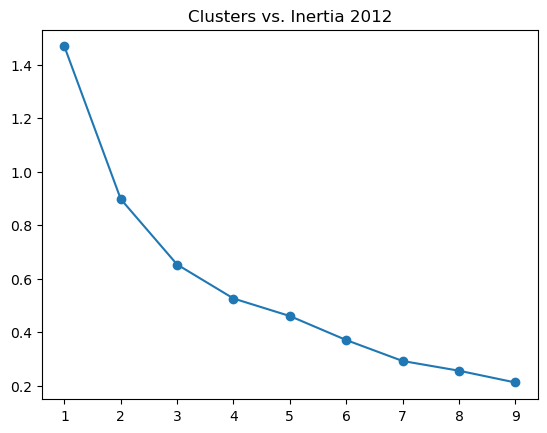

In [35]:
## plot the clusters and their inertia
## use the 'elbow' method to find where the line starts to even out
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia 2012')
plt.show()

In [36]:
## the line started to even out around 6
kmeans = KMeans(n_clusters=6, random_state=42) # <-- create 6 clusters, use a random state
kmeans.fit(combined_geo[features_2012]) # <-- fit the model to the '12 features

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [37]:
## create a new column to store the kmeans labels
combined_geo['kmeans_label_12'] = kmeans.labels_

In [38]:
## count the number of counties in each kmeans category
combined_geo['kmeans_label_12'].value_counts()

kmeans_label_12
1    5
4    4
3    4
2    4
0    2
5    1
Name: count, dtype: int64

<Axes: >

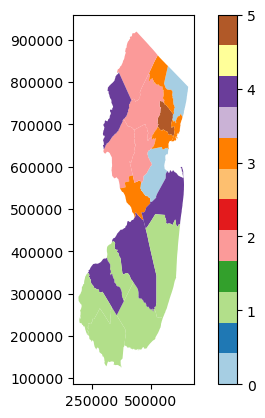

In [39]:
## plot the kmeans labels on the counties map we created earlier
combined_geo.plot(
    column = "kmeans_label_12",
    cmap = "Paired",
    legend = True)

In [40]:
cluster_feature_averages_12 = combined_geo.groupby('kmeans_label_12')[features_2012].mean().T
cluster_feature_averages_12

kmeans_label_12,0,1,2,3,4,5
pct_college_12,0.180311,0.101157,0.183571,0.134320,0.146920,0.126693
pct_hispanic_12,0.172734,0.146303,0.090662,0.304491,0.070088,0.203544
pct_black_12,0.070112,0.137441,0.039312,0.156860,0.089735,0.393187
pct_asian_12,0.181291,0.033173,0.070675,0.080037,0.036246,0.045909
pct_rep_12,0.163774,0.225880,0.342983,0.136614,0.251756,0.093915
pct_dem_12,0.335241,0.270978,0.205382,0.400559,0.281479,0.453291
pct_none_12,0.500984,0.503142,0.451635,0.462828,0.466766,0.452793
pct_foreign_born_12,0.297936,0.097415,0.142205,0.293880,0.091514,0.244607
unemployed_12,0.082000,0.118800,0.076250,0.094500,0.091250,0.108000
income_12,0.773031,0.545491,0.915983,0.612410,0.734194,0.519711


In [41]:
## how do the various clusters vary across each row?
cluster_feature_averages_12['variance'] = cluster_feature_averages_12.apply(lambda x: x.var(), axis=1)
cluster_feature_averages_12.sort_values('variance', ascending = False)

kmeans_label_12,0,1,2,3,4,5,variance
income_12,0.773031,0.545491,0.915983,0.612410,0.734194,0.519711,0.023112
pct_black_12,0.070112,0.137441,0.039312,0.156860,0.089735,0.393187,0.016316
pct_foreign_born_12,0.297936,0.097415,0.142205,0.293880,0.091514,0.244607,0.009170
pct_dem_12,0.335241,0.270978,0.205382,0.400559,0.281479,0.453291,0.008278
pct_rep_12,0.163774,0.225880,0.342983,0.136614,0.251756,0.093915,0.008068
pct_hispanic_12,0.172734,0.146303,0.090662,0.304491,0.070088,0.203544,0.007177
pct_asian_12,0.181291,0.033173,0.070675,0.080037,0.036246,0.045909,0.003088
pct_college_12,0.180311,0.101157,0.183571,0.134320,0.146920,0.126693,0.001022
pct_none_12,0.500984,0.503142,0.451635,0.462828,0.466766,0.452793,0.000540
unemployed_12,0.082000,0.118800,0.076250,0.094500,0.091250,0.108000,0.000254


### 2016

In [42]:
## identify the indicators we want to analyze
features_2016 = [
    'pct_college_16',
    'pct_hispanic_16',
    'pct_black_16',
    'pct_asian_16',
    'pct_rep_16',
    'pct_dem_16',
    'pct_none_16',
    'pct_foreign_born_16',
    'unemployed_16',
    'income_16'
]

In [43]:
## create an empty array to write the kmeans to
inertias = []

In [44]:
for i in range(1,10): # <-- loop through...
    kmeans = KMeans(n_clusters=i) # <-- assign every "i" in the loop to n_clusters, perform kmeans on each
    kmeans.fit(combined_geo[features_2016]) # <-- fit the model to each feature
    inertias.append(kmeans.inertia_) # <-- measure how well the dataset was clustered by kmeans

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

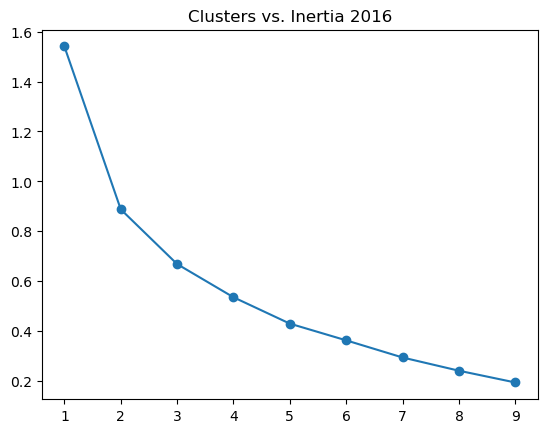

In [45]:
## plot the clusters and their inertia
## use the 'elbow' method to find where the line starts to even out
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia 2016')
plt.show()

In [46]:
## the line started to even out around 6
kmeans = KMeans(n_clusters=6, random_state=42) # <-- create 6 clusters, use a random state
kmeans.fit(combined_geo[features_2016]) # <-- fit the model to the '12 features

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [47]:
## create a new column to store the kmeans labels
combined_geo['kmeans_label_16'] = kmeans.labels_

In [48]:
## count the number of counties in each kmeans category
combined_geo['kmeans_label_16'].value_counts()

kmeans_label_16
0    4
2    4
5    3
3    3
1    3
4    3
Name: count, dtype: int64

<Axes: >

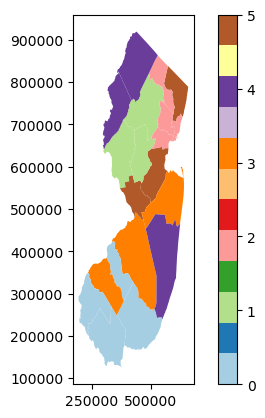

In [49]:
## plot the kmeans labels on the counties map we created earlier
combined_geo.plot(
    column = "kmeans_label_16",
    cmap = "Paired",
    legend = True)

In [50]:
cluster_feature_averages_16 = combined_geo.groupby('kmeans_label_16')[features_2016].mean().T
cluster_feature_averages_16

kmeans_label_16,0,1,2,3,4,5
pct_college_16,0.104834,0.206725,0.139113,0.161198,0.143685,0.172438
pct_hispanic_16,0.177534,0.109424,0.337485,0.078095,0.080953,0.182682
pct_black_16,0.160231,0.047764,0.202208,0.107604,0.029688,0.114182
pct_asian_16,0.039953,0.099930,0.073936,0.043296,0.021823,0.165541
pct_rep_16,0.202319,0.333016,0.128391,0.234529,0.363542,0.166105
pct_dem_16,0.345829,0.256943,0.457941,0.331219,0.207967,0.382880
pct_none_16,0.451852,0.410041,0.413668,0.434252,0.428491,0.451015
pct_foreign_born_16,0.107582,0.172698,0.314789,0.093678,0.084933,0.280812
unemployed_16,0.066500,0.038667,0.054500,0.046000,0.048000,0.042667
income_16,0.530062,0.965640,0.572890,0.757780,0.688671,0.749294


In [51]:
## how do the various clusters vary across each row?
cluster_feature_averages_16['variance'] = cluster_feature_averages_16.apply(lambda x: x.var(), axis=1)
cluster_feature_averages_16.sort_values('variance', ascending = False)

kmeans_label_16,0,1,2,3,4,5,variance
income_16,0.530062,0.965640,0.572890,0.757780,0.688671,0.749294,0.024161
pct_foreign_born_16,0.107582,0.172698,0.314789,0.093678,0.084933,0.280812,0.010002
pct_hispanic_16,0.177534,0.109424,0.337485,0.078095,0.080953,0.182682,0.009566
pct_rep_16,0.202319,0.333016,0.128391,0.234529,0.363542,0.166105,0.008651
pct_dem_16,0.345829,0.256943,0.457941,0.331219,0.207967,0.382880,0.007929
pct_black_16,0.160231,0.047764,0.202208,0.107604,0.029688,0.114182,0.004274
pct_asian_16,0.039953,0.099930,0.073936,0.043296,0.021823,0.165541,0.002775
pct_college_16,0.104834,0.206725,0.139113,0.161198,0.143685,0.172438,0.001183
pct_none_16,0.451852,0.410041,0.413668,0.434252,0.428491,0.451015,0.000318
unemployed_16,0.066500,0.038667,0.054500,0.046000,0.048000,0.042667,0.000098


### 2020

In [52]:
## identify the indicators we want to analyze
features_2020 = [
    'pct_college_20',
    'pct_hispanic_20',
    'pct_black_20',
    'pct_asian_20',
    'pct_rep_20',
    'pct_dem_20',
    'pct_none_20',
    'pct_foreign_born_20',
    'unemployed_20',
    'income_20'
]

In [53]:
## create an empty array to write the kmeans to
inertias = []

In [54]:
for i in range(1,10): # <-- loop through...
    kmeans = KMeans(n_clusters=i) # <-- assign every "i" in the loop to n_clusters, perform kmeans on each
    kmeans.fit(combined_geo[features_2020]) # <-- fit the model to each feature
    inertias.append(kmeans.inertia_) # <-- measure how well the dataset was clustered by kmeans

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

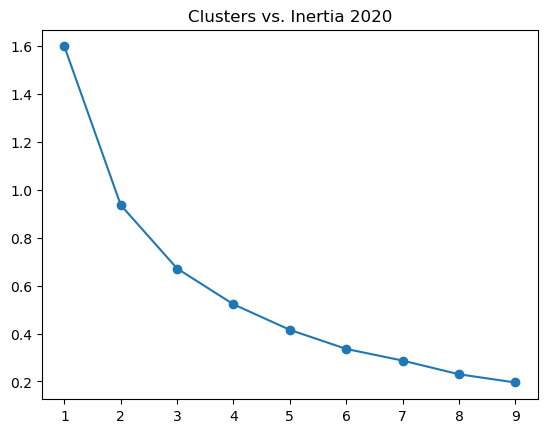

In [55]:
## plot the clusters and their inertia
## use the 'elbow' method to find where the line starts to even out
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia 2020')
plt.show()

In [56]:
## the line started to even out around 6
kmeans = KMeans(n_clusters=6, random_state=42) # <-- create 6 clusters, use a random state
kmeans.fit(combined_geo[features_2020]) # <-- fit the model to the '12 features

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [57]:
## create a new column to store the kmeans labels
combined_geo['kmeans_label_20'] = kmeans.labels_

In [58]:
## count the number of counties in each kmeans category
combined_geo['kmeans_label_20'].value_counts()

kmeans_label_20
4    5
2    4
1    4
3    3
5    3
0    1
Name: count, dtype: int64

<Axes: >

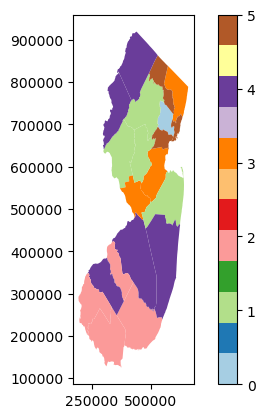

In [59]:
## plot the kmeans labels on the counties map we created earlier
combined_geo.plot(
    column = "kmeans_label_20",
    cmap = "Paired",
    legend = True)

In [60]:
cluster_feature_averages_20 = combined_geo.groupby('kmeans_label_20')[features_2020].mean().T
cluster_feature_averages_20

kmeans_label_20,0,1,2,3,4,5
pct_college_20,0.143105,0.217819,0.111295,0.185843,0.163344,0.157879
pct_hispanic_20,0.232651,0.114597,0.192814,0.198871,0.084937,0.387945
pct_black_20,0.380208,0.053908,0.159365,0.114636,0.070988,0.136449
pct_asian_20,0.054187,0.095561,0.039571,0.174343,0.029352,0.086713
pct_rep_20,0.099931,0.319415,0.232939,0.177745,0.335445,0.154450
pct_dem_20,0.520298,0.301023,0.378452,0.424645,0.300800,0.483227
pct_none_20,0.379771,0.379562,0.388609,0.397610,0.363755,0.362323
pct_foreign_born_20,0.276513,0.172784,0.102195,0.289030,0.080993,0.352734
unemployed_20,0.112000,0.076000,0.116000,0.083000,0.086200,0.106000
income_20,0.542678,0.965545,0.540014,0.790952,0.732717,0.654087


In [61]:
## how do the various clusters vary across each row?
cluster_feature_averages_20['variance'] = cluster_feature_averages_20.apply(lambda x: x.var(), axis=1)
cluster_feature_averages_20.sort_values('variance', ascending = False)

kmeans_label_20,0,1,2,3,4,5,variance
income_20,0.542678,0.965545,0.540014,0.790952,0.732717,0.654087,0.026440
pct_black_20,0.380208,0.053908,0.159365,0.114636,0.070988,0.136449,0.013991
pct_foreign_born_20,0.276513,0.172784,0.102195,0.289030,0.080993,0.352734,0.012132
pct_hispanic_20,0.232651,0.114597,0.192814,0.198871,0.084937,0.387945,0.011390
pct_rep_20,0.099931,0.319415,0.232939,0.177745,0.335445,0.154450,0.008775
pct_dem_20,0.520298,0.301023,0.378452,0.424645,0.300800,0.483227,0.008419
pct_asian_20,0.054187,0.095561,0.039571,0.174343,0.029352,0.086713,0.002811
pct_college_20,0.143105,0.217819,0.111295,0.185843,0.163344,0.157879,0.001324
unemployed_20,0.112000,0.076000,0.116000,0.083000,0.086200,0.106000,0.000284
pct_none_20,0.379771,0.379562,0.388609,0.397610,0.363755,0.362323,0.000190


### 2024

In [62]:
## identify the indicators we want to analyze
features_2024 = [
    'pct_college_24',
    'pct_hispanic_24',
    'pct_black_24',
    'pct_asian_24',
    'pct_rep_24',
    'pct_dem_24',
    'pct_none_24',
    'pct_foreign_born_24',
    'unemployed_24',
    'income_24'
]

In [63]:
## create an empty array to write the kmeans to
inertias = []

In [64]:
for i in range(1,10): # <-- loop through...
    kmeans = KMeans(n_clusters=i) # <-- assign every "i" in the loop to n_clusters, perform kmeans on each
    kmeans.fit(combined_geo[features_2024]) # <-- fit the model to each feature
    inertias.append(kmeans.inertia_) # <-- measure how well the dataset was clustered by kmeans

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

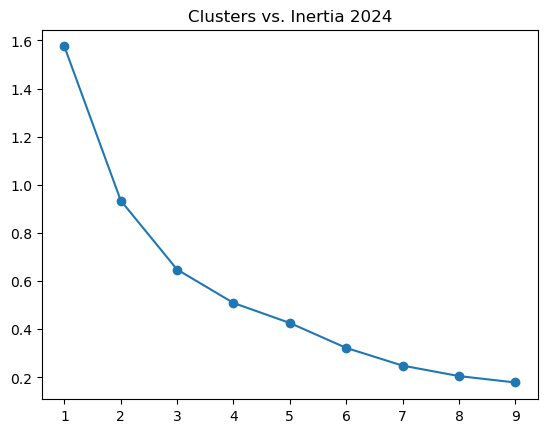

In [65]:
## plot the clusters and their inertia
## use the 'elbow' method to find where the line starts to even out
plt.plot(range(1,10), inertias, marker='o')
plt.title('Clusters vs. Inertia 2024')
plt.show()

In [66]:
## the line started to even out around 6
kmeans = KMeans(n_clusters=6, random_state=42) # <-- create 6 clusters, use a random state
kmeans.fit(combined_geo[features_2024]) # <-- fit the model to the '12 features

/Users/miahollie/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [67]:
## create a new column to store the kmeans labels
combined_geo['kmeans_label_24'] = kmeans.labels_

In [68]:
## count the number of counties in each kmeans category
combined_geo['kmeans_label_24'].value_counts()

kmeans_label_24
1    6
0    3
3    3
4    3
2    3
5    2
Name: count, dtype: int64

<Axes: >

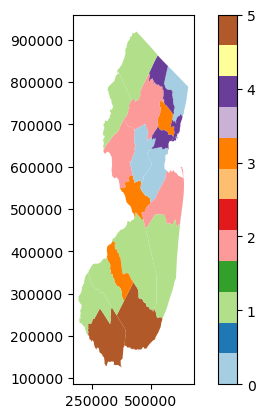

In [69]:
## plot the kmeans labels on the counties map we created earlier
combined_geo.plot(
    column = "kmeans_label_24",
    cmap = "Paired",
    legend = True)

In [70]:
## what do the clusters look like? 
cluster_feature_averages_24 = combined_geo.groupby('kmeans_label_24')[features_2024].mean().T
cluster_feature_averages_24

kmeans_label_24,0,1,2,3,4,5
pct_college_24,0.206332,0.158996,0.227702,0.150591,0.162876,0.108443
pct_hispanic_24,0.197747,0.094884,0.108852,0.204629,0.395688,0.260871
pct_black_24,0.079760,0.082358,0.038841,0.246205,0.134375,0.153004
pct_asian_24,0.201281,0.026741,0.068338,0.078871,0.088767,0.045635
pct_rep_24,0.223416,0.354280,0.358890,0.148793,0.172145,0.276578
pct_dem_24,0.380796,0.293256,0.289113,0.476109,0.459696,0.335175
pct_none_24,0.395787,0.352463,0.351998,0.375098,0.368159,0.388246
pct_foreign_born_24,0.307844,0.075840,0.143268,0.217950,0.355959,0.133297
unemployed_24,0.043000,0.047833,0.039667,0.051333,0.053333,0.067000
income_24,0.888333,0.701137,0.955734,0.620284,0.664797,0.507073


In [71]:
## how do the various clusters vary across each row?
cluster_feature_averages_24['variance'] = cluster_feature_averages_24.apply(lambda x: x.var(), axis=1)
cluster_feature_averages_24.sort_values('variance', ascending = False)

kmeans_label_24,0,1,2,3,4,5,variance
income_24,0.888333,0.701137,0.955734,0.620284,0.664797,0.507073,0.028508
pct_hispanic_24,0.197747,0.094884,0.108852,0.204629,0.395688,0.260871,0.012146
pct_foreign_born_24,0.307844,0.075840,0.143268,0.217950,0.355959,0.133297,0.011833
pct_rep_24,0.223416,0.354280,0.358890,0.148793,0.172145,0.276578,0.008051
pct_dem_24,0.380796,0.293256,0.289113,0.476109,0.459696,0.335175,0.006607
pct_black_24,0.079760,0.082358,0.038841,0.246205,0.134375,0.153004,0.005362
pct_asian_24,0.201281,0.026741,0.068338,0.078871,0.088767,0.045635,0.003759
pct_college_24,0.206332,0.158996,0.227702,0.150591,0.162876,0.108443,0.001797
pct_none_24,0.395787,0.352463,0.351998,0.375098,0.368159,0.388246,0.000327
unemployed_24,0.043000,0.047833,0.039667,0.051333,0.053333,0.067000,0.000092
